In [1]:
#load simulation data with loadSimDataOneHot
from simDataPreprocessing import loadSimDataOneHot

data, labels = loadSimDataOneHot('/mnt/d/data/MIME_data/simData/dmMIME/seqLen100/highError', maxNumSequences=1000000, splittingProbability=3/100, readSize=23)

first round prot1 done
first round prot6 done
first round prot15 done
first round prot 30 done


In [3]:
data.shape, labels.shape

((1550560, 408), (1550560, 1))

In [4]:
#split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1395504, 408), (155056, 408), (1395504, 1), (155056, 1))

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [7]:
#load data into torch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [8]:
#load data into torch datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [9]:
#set model parameters
batch_size = 128
learning_rate = 0.001
num_epochs = 20
lambda_l1 = 0.0001
size_factor_hidden = 10
bottle_neck_factor = 2/size_factor_hidden

In [10]:
#load data into torch dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
#set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
#set input and output dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

In [13]:
#define 4 layer neural network with relu activation function and sigmoid output
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #first layer with input_dim input neurons and inputdim*size_factor_hidden output neurons
        self.fc1 = nn.Linear(input_dim, input_dim*size_factor_hidden)
        #second layer with inputdim*size_factor_hidden input neurons and inputdim*size_factor_hidden output neurons
        self.fc2 = nn.Linear(input_dim*size_factor_hidden, input_dim*size_factor_hidden)
        #third layer with inputdim*size_factor_hidden input neurons and inputdim*size_factor_hidden output neurons
        self.fc3 = nn.Linear(input_dim*size_factor_hidden, input_dim*size_factor_hidden)
        #fourth layer with inputdim*size_factor_hidden input neurons and inputdim output neurons
        self.fc4 = nn.Linear(input_dim*size_factor_hidden, int(input_dim*size_factor_hidden*bottle_neck_factor))
        #fifth layer with inputdim input neurons and output_dim output neurons
        self.fc5 = nn.Linear(int(input_dim*size_factor_hidden*bottle_neck_factor), output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x



In [14]:
#initialize model
model = Net()
model.to(device)

Net(
  (fc1): Linear(in_features=408, out_features=4080, bias=True)
  (fc2): Linear(in_features=4080, out_features=4080, bias=True)
  (fc3): Linear(in_features=4080, out_features=4080, bias=True)
  (fc4): Linear(in_features=4080, out_features=816, bias=True)
  (fc5): Linear(in_features=816, out_features=1, bias=True)
)

In [15]:
#set loss function and adam optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
#import tqdm notebook for progress bar
from tqdm import tqdm

In [17]:
#train model on gpu and track training and test loss
train_losses = []
test_losses = []
batch_losses = []
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    train_loss = 0
    test_loss = 0
    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        l1_norm = 0
        for param in model.parameters():
            l1_norm += torch.norm(param, 1)
        loss = criterion(output, target) + lambda_l1*l1_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        batch_losses.append(loss.item())
    train_losses.append(train_loss/len(train_loader))
    model.eval()
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target) + lambda_l1*l1_norm
        test_loss += loss.item()
    test_losses.append(test_loss/len(test_loader))

Epoch 1/20


100%|██████████| 1212/1212 [00:02<00:00, 582.58it/s]


Epoch 2/20


100%|██████████| 1212/1212 [00:01<00:00, 610.87it/s]


Epoch 3/20


100%|██████████| 1212/1212 [00:02<00:00, 551.62it/s]


Epoch 4/20


100%|██████████| 1212/1212 [00:02<00:00, 544.10it/s]


Epoch 5/20


100%|██████████| 1212/1212 [00:02<00:00, 539.02it/s]


Epoch 6/20


100%|██████████| 1212/1212 [00:02<00:00, 555.27it/s]


Epoch 7/20


100%|██████████| 1212/1212 [00:02<00:00, 584.80it/s]


Epoch 8/20


100%|██████████| 1212/1212 [00:02<00:00, 564.79it/s]


Epoch 9/20


100%|██████████| 1212/1212 [00:02<00:00, 519.63it/s]


Epoch 10/20


100%|██████████| 1212/1212 [00:02<00:00, 548.32it/s]


Epoch 11/20


100%|██████████| 1212/1212 [00:02<00:00, 535.53it/s]


Epoch 12/20


100%|██████████| 1212/1212 [00:02<00:00, 510.06it/s]


Epoch 13/20


100%|██████████| 1212/1212 [00:02<00:00, 578.45it/s]


Epoch 14/20


100%|██████████| 1212/1212 [00:02<00:00, 562.39it/s]


Epoch 15/20


100%|██████████| 1212/1212 [00:02<00:00, 525.65it/s]


Epoch 16/20


100%|██████████| 1212/1212 [00:02<00:00, 544.43it/s]


Epoch 17/20


100%|██████████| 1212/1212 [00:02<00:00, 580.44it/s]


Epoch 18/20


100%|██████████| 1212/1212 [00:02<00:00, 582.17it/s]


Epoch 19/20


100%|██████████| 1212/1212 [00:02<00:00, 587.94it/s]


Epoch 20/20


100%|██████████| 1212/1212 [00:02<00:00, 587.01it/s]


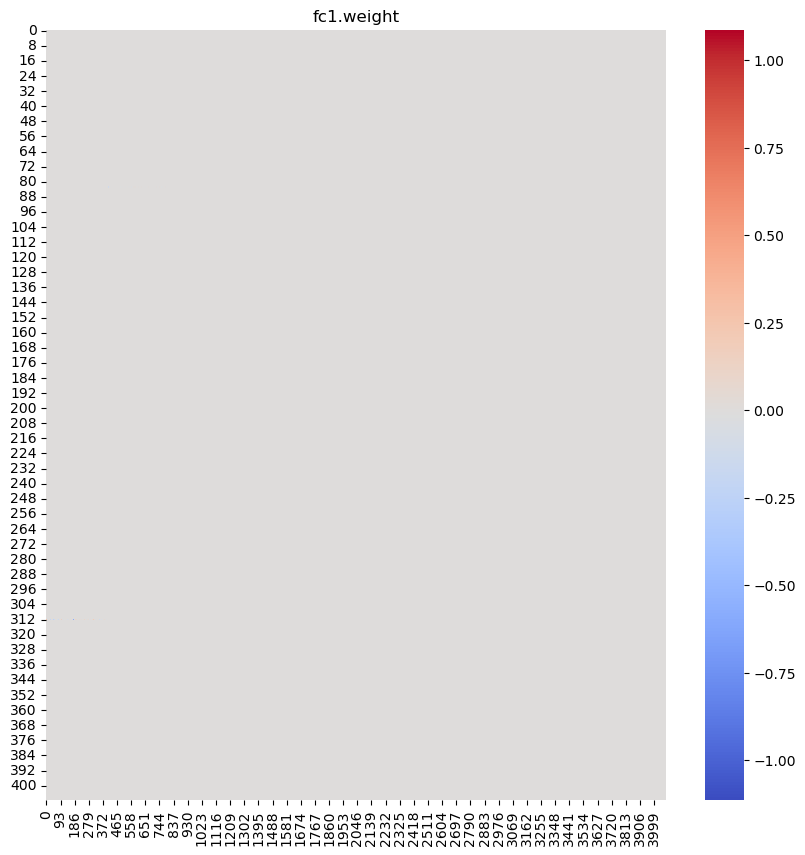

max weight value:  1.0868905
min weight value:  -1.1134431


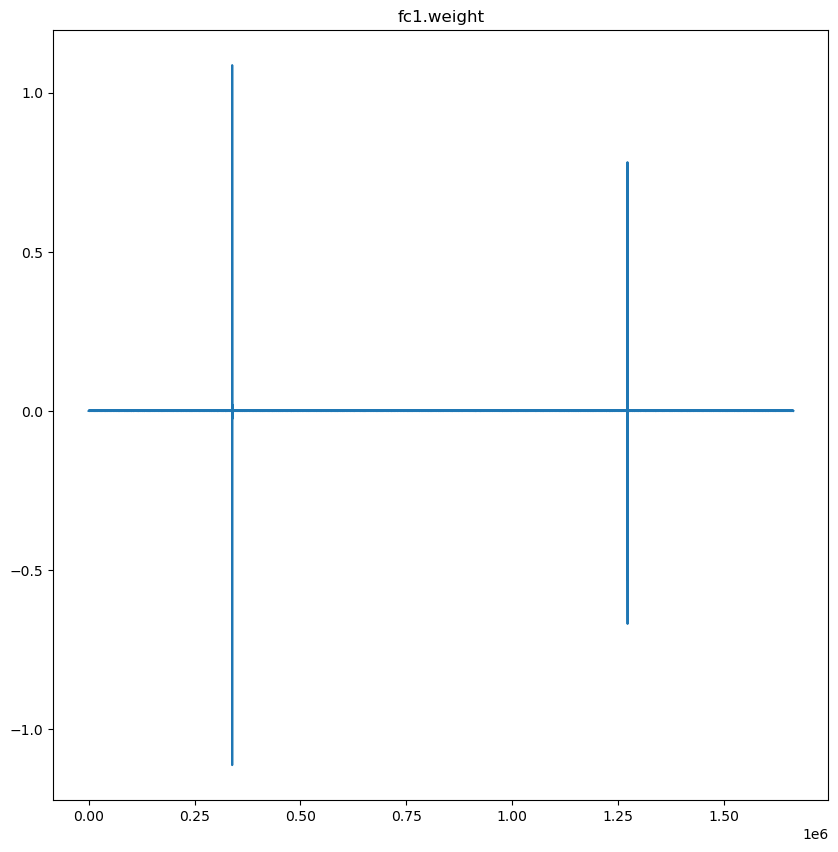

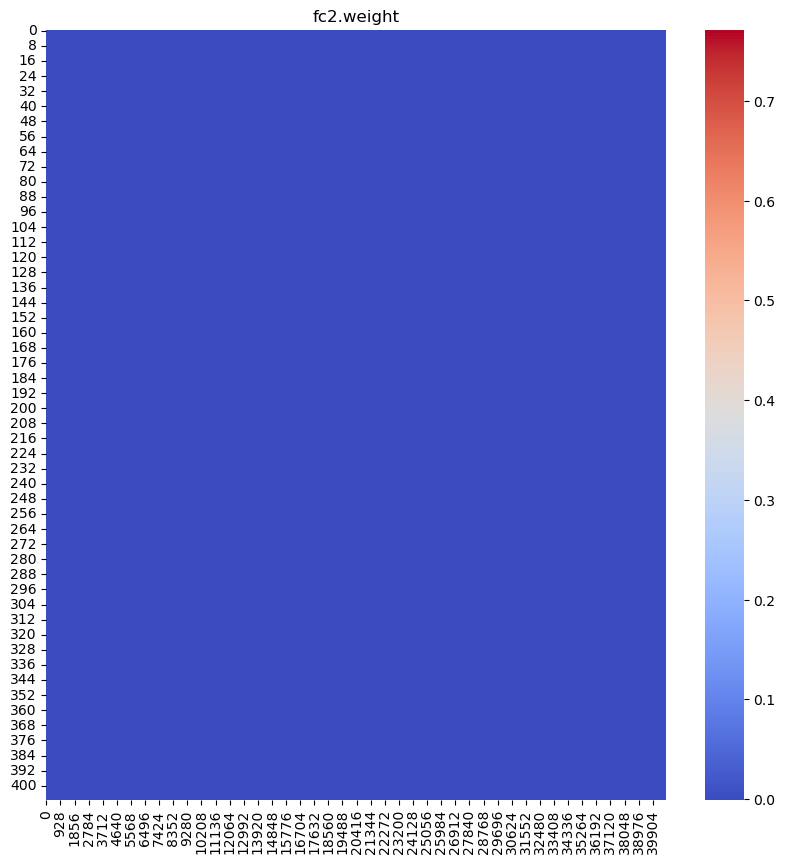

max weight value:  0.7711641
min weight value:  -0.00085525605


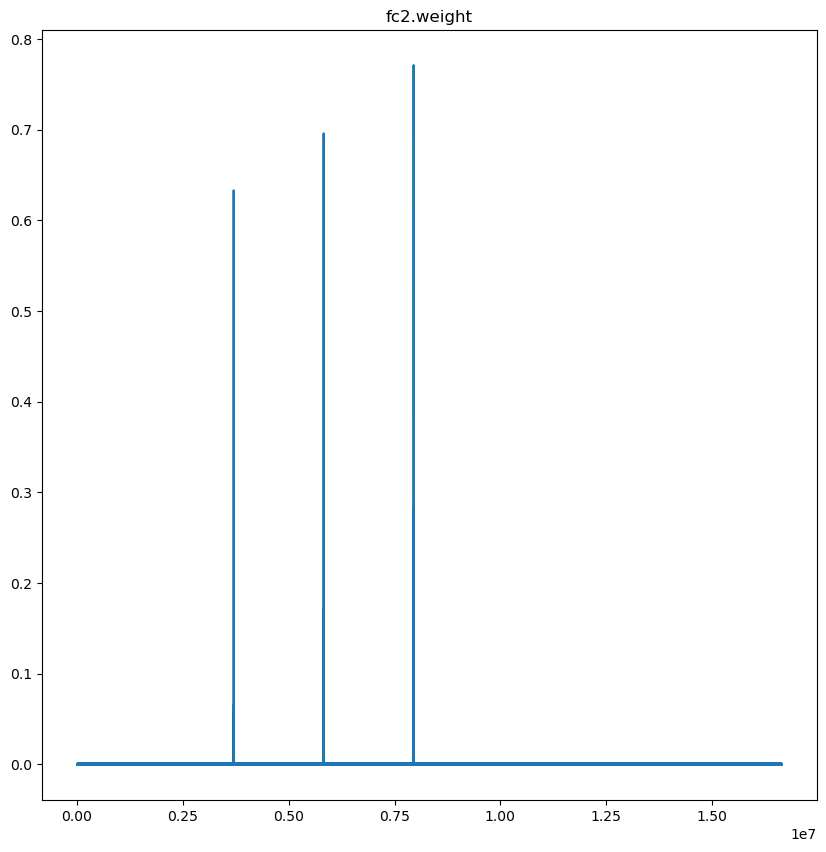

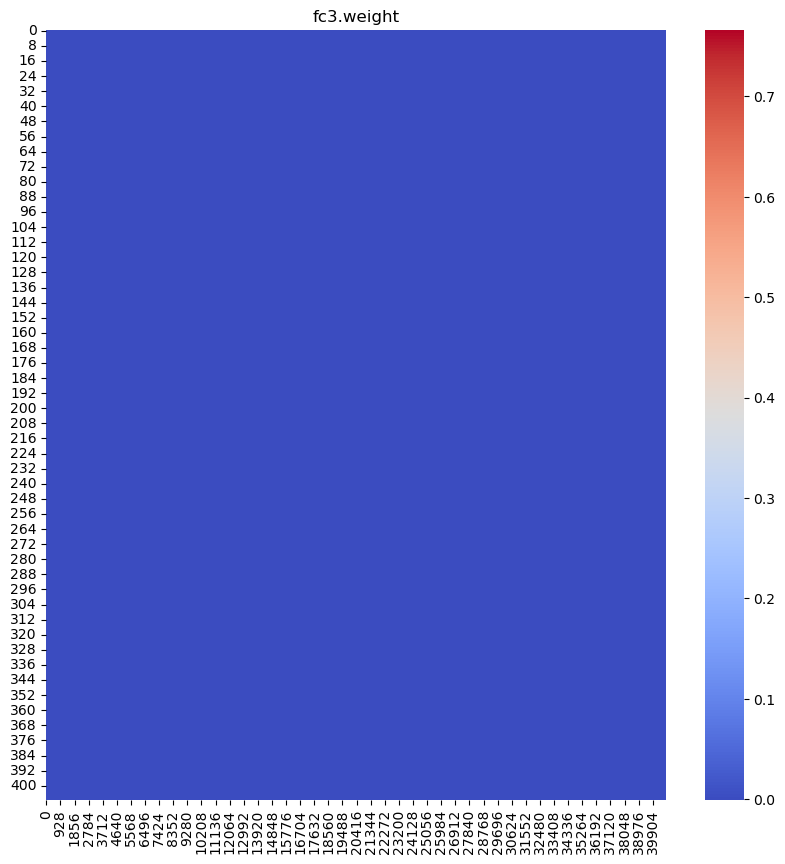

max weight value:  0.76623595
min weight value:  -0.0007920139


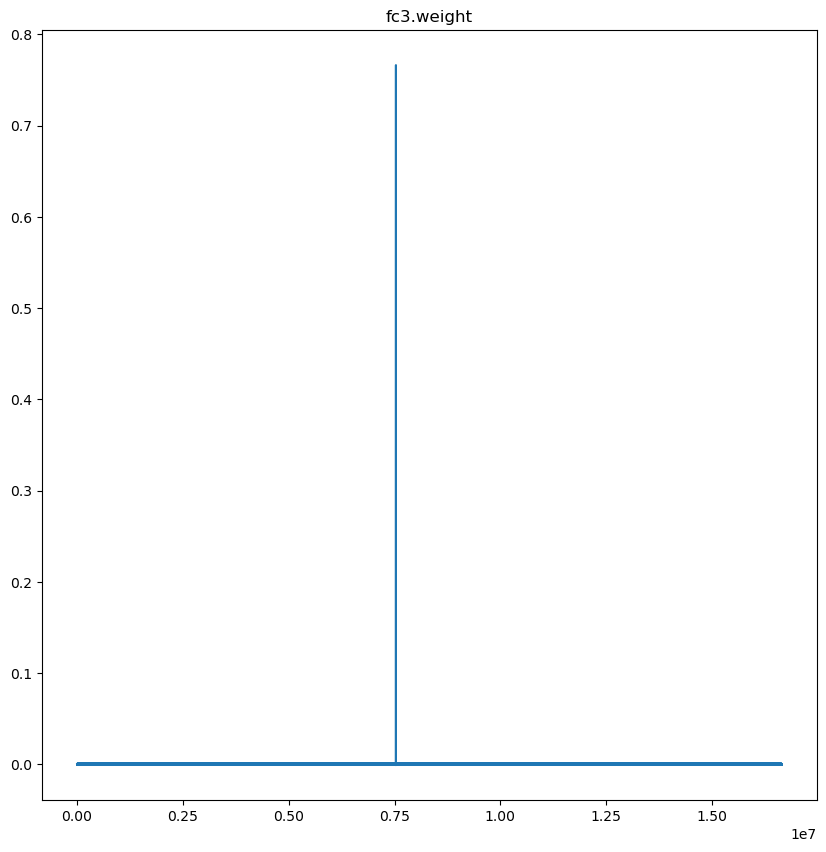

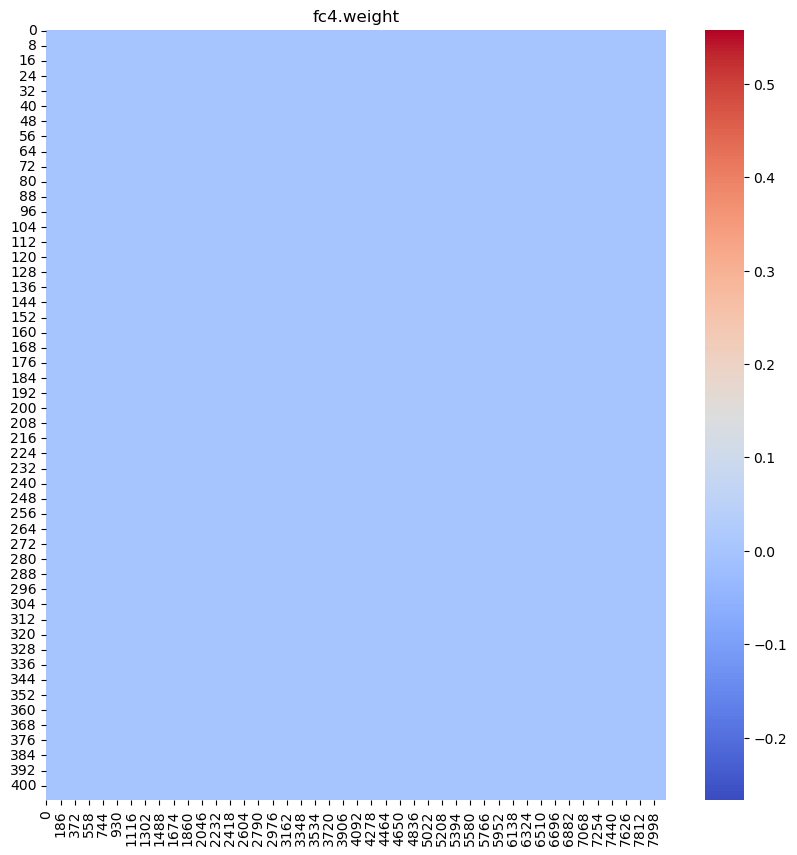

max weight value:  0.55768865
min weight value:  -0.2664309


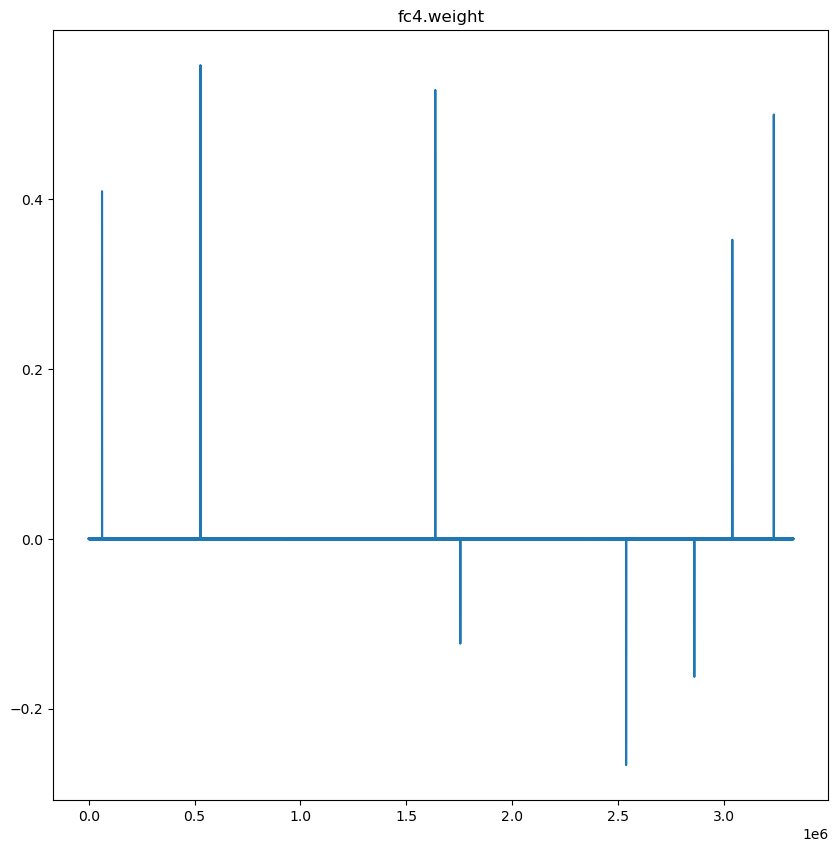

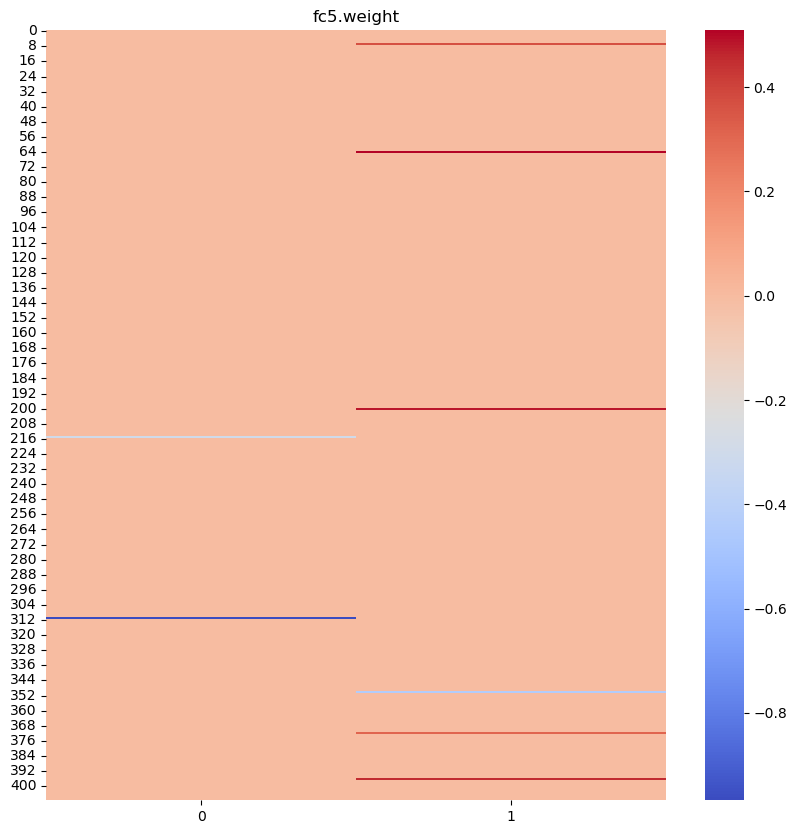

max weight value:  0.5089945
min weight value:  -0.9677698


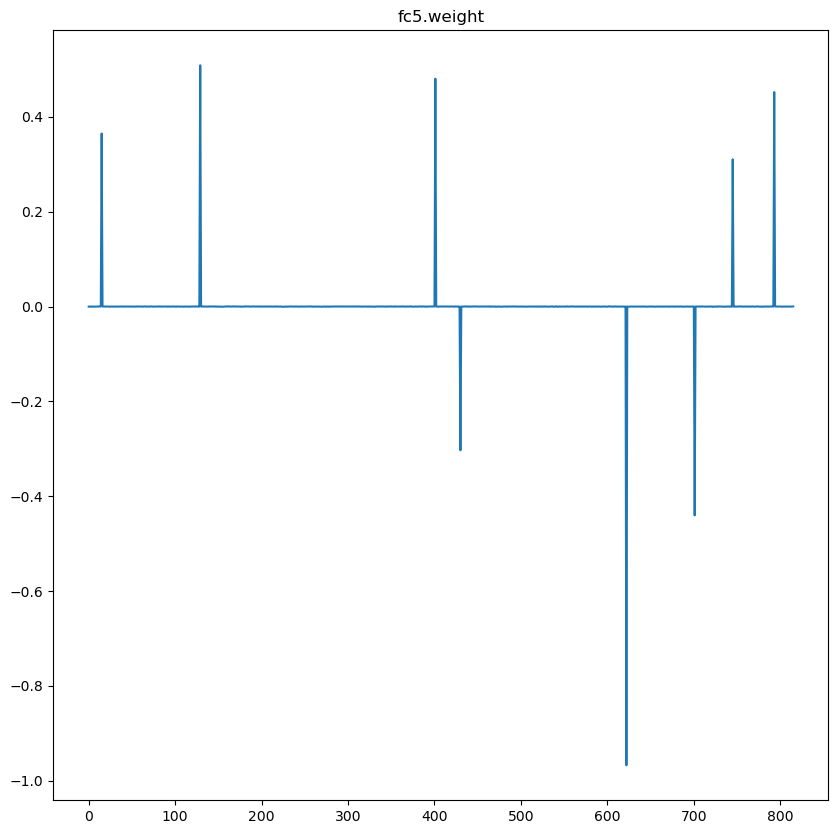

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#iterate through individual weights and count weights with value 0
for name, param in model.named_parameters():
    #if weight is not a bias
    if 'bias' not in name:
        #reshape weights to 2d array
        weight = param.data.cpu().numpy().reshape(input_dim, -1)
        #plot heatmap of weights
        plt.figure(figsize=(10,10))
        sns.heatmap(weight, cmap='coolwarm')
        plt.title(name)
        plt.show()
        #print maximum and minimum weight value
        print('max weight value: ', np.max(weight))
        print('min weight value: ', np.min(weight))
        #plot histogram of weights
        plt.figure(figsize=(10,10))
        sns.lineplot(weight.flatten())
        plt.title(name)
        plt.show()

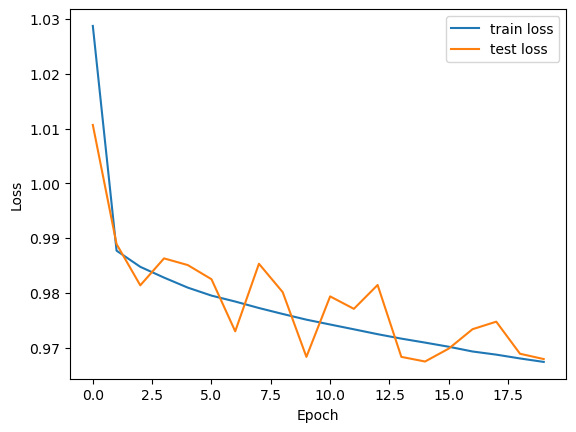

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot training and test loss
sns.lineplot(x= range(len(train_losses)), y=train_losses, label='train loss')
sns.lineplot(x=range(len(test_losses)), y=test_losses, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [20]:
#get error on training and test set
def getError(model, loader):
    error = 0
    model.eval()
    for data, target in tqdm(loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        error += torch.sum(torch.abs(torch.round(output) - target)).item()
    return error/len(loader.dataset)

train_error = getError(model, train_loader)
test_error = getError(model, test_loader)
print('Training error: {}'.format(train_error))
print('Test error: {}'.format(test_error))

100%|██████████| 1212/1212 [00:02<00:00, 552.77it/s]

Training error: 0.23837480938786273
Test error: 0.24023578578062119


# first checks
bottlenecking the last 2 layers is fine

size_factor_hidden 10/20 no diff

data amount with 50000 results in low variance 

unavoidable error for samples that end up 50/50 in bound/unbound

-> change loss and label to frquencies in pools

In [21]:
import numpy as np

# read in kd values
kds = np.loadtxt('/mnt/d/data/MIME_data/simData/dmMIME/seqLen100/highError/secondFromProt1/prot1/single_kds.txt')

#insert 1 at position 0 and then every 3rd position
kds = np.insert(kds, 0, 1)
kds = np.insert(kds, np.arange(4, len(kds), 3), 1)
kds[0:10]

array([1.     , 1.     , 1.     , 1.60675, 1.     , 1.     , 1.27897,
       1.     , 1.     , 3.32221])

In [22]:
predictionsZeroConc = []
prediction_example = np.zeros(len(kds)+8)
for i in range(8, len(kds)+8):
    current_prediction_example = prediction_example.copy()
    current_prediction_example[i] = 1
    current_prediction_example = torch.from_numpy(current_prediction_example).float()
    current_prediction_example = current_prediction_example.to(device)
    #output binding probability and append list for given protein concentration combination
    with torch.no_grad():
        output = model(current_prediction_example)
        predictionsZeroConc.append(output.item())

predictionsOneConc = []
prediction_example = np.zeros(len(kds)+8)
for i in range(8, len(kds)+8):
    current_prediction_example = prediction_example.copy()
    current_prediction_example[i] = 1
    current_prediction_example = torch.from_numpy(current_prediction_example).float()
    current_prediction_example = current_prediction_example.to(device)
    #output binding probability and append list for given protein concentration combination
    with torch.no_grad():
        output = model(current_prediction_example)
        predictionsOneConc.append(output.item())

In [23]:
print(len(predictionsZeroConc))
print(len(predictionsOneConc))
print(len(kds))

400
400
400


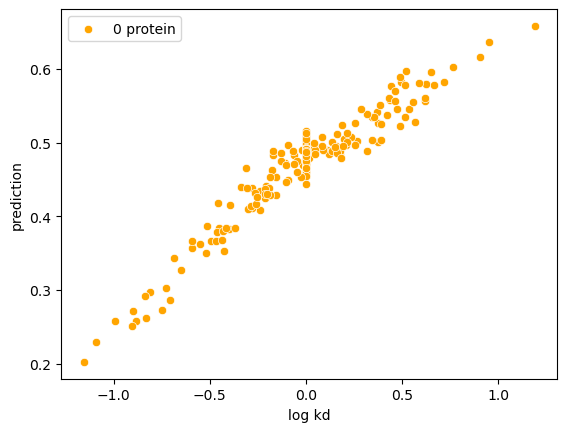

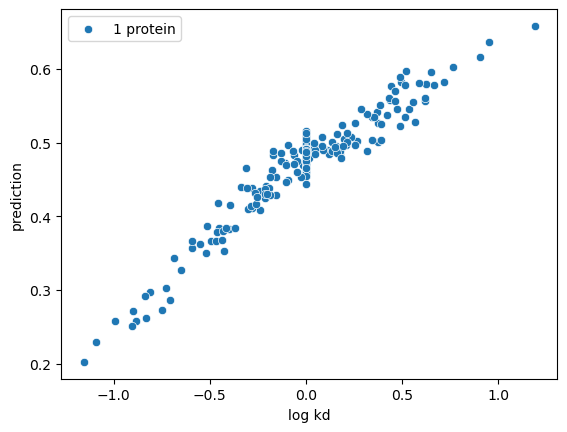

PearsonRResult(statistic=0.9424444969373741, pvalue=1.8449831273466e-191)
PearsonRResult(statistic=0.9424444969373741, pvalue=1.8449831273466e-191)


In [24]:
#two plots -log kd vs predictionZeroConc and predictionOneConc
sns.scatterplot(x=-np.log10(kds), y=predictionsZeroConc, label='0 protein', color='orange')
plt.xlabel('log kd')
plt.ylabel('prediction')
plt.show()
sns.scatterplot(x=-np.log10(kds), y=predictionsOneConc, label='1 protein')
plt.xlabel('log kd')
plt.ylabel('prediction')
plt.show()

#get correlation between predictions and kd values
from scipy.stats import pearsonr
print(pearsonr(-np.log(kds), predictionsZeroConc))
print(pearsonr(-np.log(kds), predictionsOneConc))


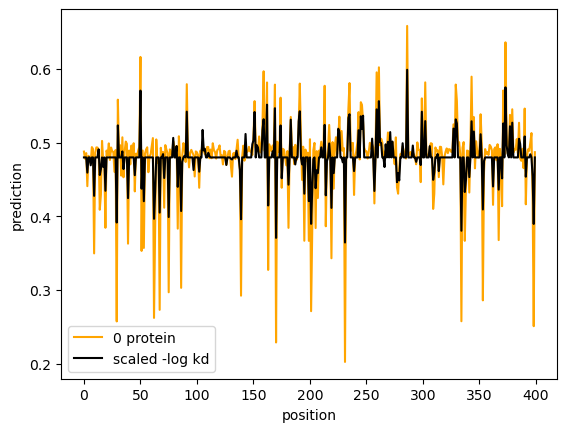

In [25]:
#lineplot of predictionsZeroConc
sns.lineplot(x=np.arange(0, len(predictionsZeroConc)), y=predictionsZeroConc, label='0 protein', color='orange')
#add (-log(kd) + mean)/variance of predictionsZeroConc

sns.lineplot(x=np.arange(0, len(predictionsZeroConc)), y=-np.log10(kds)/10+np.mean(predictionsZeroConc), label='scaled -log kd', color='black')
plt.xlabel('position')
plt.ylabel('prediction')
plt.show()

In [26]:
#save inferred probabilities for all protein concentration combinations

#initialize dictionary to store inferred probabilities
inferred_probs = {}

proteinConcentrations = [1,2,3,4]

#loop over protein concentrations
for protConc1 in proteinConcentrations:
    for protConc2 in proteinConcentrations:
        #create prediction example for current protein concentration combination and zeros for all kd values
        prediction_example = np.zeros((1, len(kds)+6))
        #insert protein concentration values at position 1 and 2
        prediction_example = np.insert(prediction_example, protConc2, 1)
        prediction_example = np.insert(prediction_example, protConc1, 1)
        
        #loop to set each position to 1 and infer probability
        predictions = []
        for i in range(8, len(kds)+8):
            current_prediction_example = prediction_example.copy()
            current_prediction_example[i] = 1
            current_prediction_example = torch.from_numpy(current_prediction_example).float()
            current_prediction_example = current_prediction_example.to(device)
            #output binding probability and append list for given protein concentration combination
            with torch.no_grad():
                output = model(current_prediction_example)
                predictions.append(output.item())
        #save inferred probabilities for given protein concentration combination
        inferred_probs[(protConc1, protConc2)] = predictions
            

In [27]:
#get variance of inferred probabilities for each protein concentration combination
variances = []
for protConc1 in proteinConcentrations:
    for protConc2 in proteinConcentrations:
        variances.append(np.var(inferred_probs[(protConc1, protConc2)]))

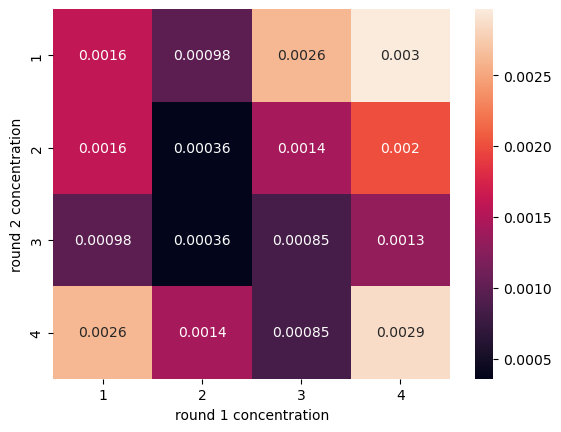

In [28]:
#plot variance of inferred probabilities for each protein concentration combination
sns.heatmap(np.array(variances).reshape(4,4), annot=True, xticklabels=proteinConcentrations, yticklabels=proteinConcentrations)
plt.xlabel('round 1 concentration')
plt.ylabel('round 2 concentration')
plt.show()

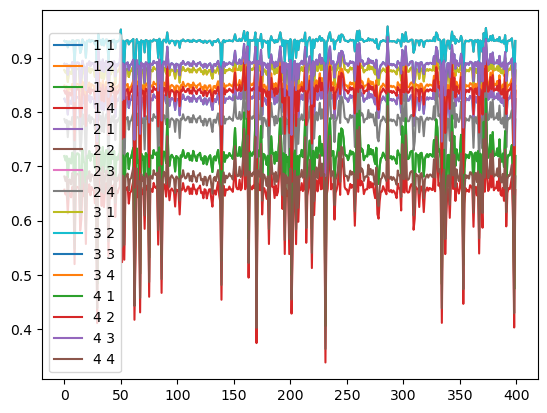

In [29]:
#plot inferred probabilities for each protein concentration combination
for protConc1 in proteinConcentrations:
    for protConc2 in proteinConcentrations:
        sns.lineplot(x=range(len(inferred_probs[(protConc1, protConc2)])), y=inferred_probs[(protConc1, protConc2)], label='{} {}'.format(protConc1, protConc2))

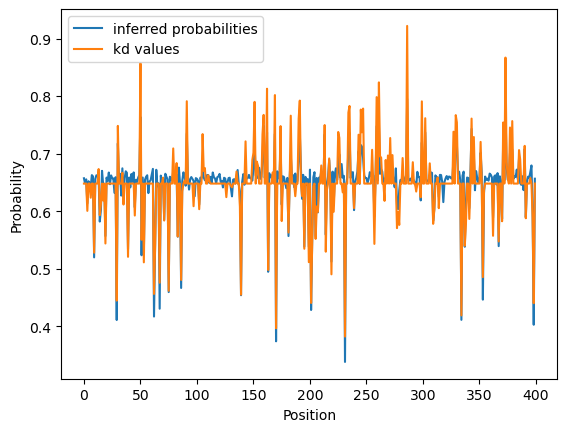

In [30]:
#plot predictions of highest variance protein concentration combination vs kd values
sns.lineplot(x=range(len(inferred_probs[(1,4)])), y=inferred_probs[(1,4)], label='inferred probabilities')
sns.lineplot(x=range(len(kds)), y=-np.log(kds)/10+np.mean(inferred_probs[(1,4)]), label='kd values')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.show()

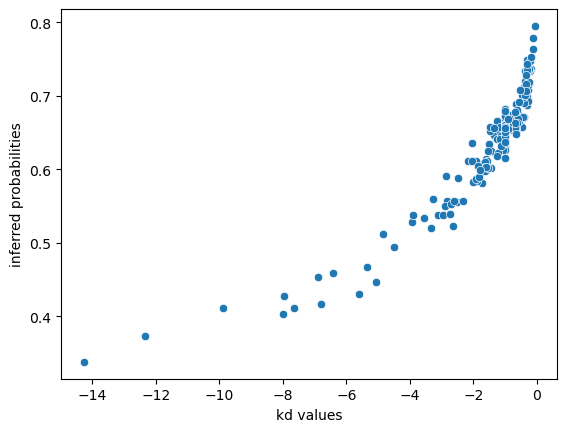

In [31]:
#scatter plot of inferred probabilities vs kd values
sns.scatterplot(x=-kds, y=inferred_probs[(1,4)])
plt.xlabel('kd values')
plt.ylabel('inferred probabilities')
plt.show()

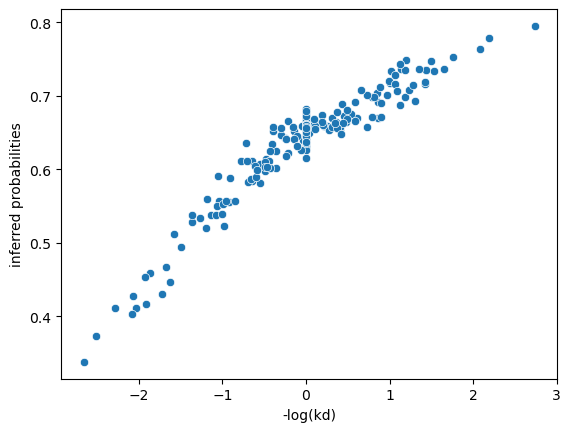

In [32]:
#scatterplot of negative log of kd values vs inferred probabilities
sns.scatterplot(x=-np.log(kds), y=inferred_probs[(1,4)])
plt.xlabel('-log(kd)')
plt.ylabel('inferred probabilities')
plt.show()